# CTA Exercises 3: NER Modeling/Prediction

## Task
End to end Named Entity Recognition or Text Summarization using a Deep Learning or a Transfer Learning model of your choosing. This includes:  
- Choosing your dataset, 
- Data preparation 
- Analysis 
- Preprocessing 
- Embedding 
- Training
- Evaluation

The minimum data analysis that is expected is
what we did in Session 5. We recommend using the same datasets as in the tutorial or picking a dataset from Huggingface datasets.

Huggingface datasets: https://huggingface.co/docs/datasets/

If you have any questions, you can reach out to me: nina.s.hristozova@gmail.com
Add your shared Colab notebook link here: https://docs.google.com/spreadsheets/d/1wi2MfvjOh5_SOYLE46RnE-lUuN1GZPwyilbaDGitxLQ/edit#gid=0
If you want that only the instructors see your Colab notebook, you can add the following emailto the shared list and
select Restricted share: hslu.clt@gmail.com

## Introduction  
I decided to take the same data as in the tutorial presented by Professor Hristozova. The only difference is that I will check the performance of the large English model `en_core_web_lg` and the transformers model `en_core_web_trf` quantify the performance. Furthermore, the code was slightly modified and adapted. 

__What is a Named Entity?__  
A named entity is basically an object which has proper identification and can be denoted with a proper name. Named Entities are:

- Places
- Persons
- Organizations
- Time
- Object
- Geographic entity.

Spacy differs between those categories:  

![](https://miro.medium.com/max/1050/1*DlrDXw3g46hRLwnlhldwcQ.png)  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Fri Dec 31 02:16:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Data
!pip install datasets
!pip install pandarallel

# Ploting
!pip install matplotlib==3.1.3

# NER: spaCy
!pip install -U pip setuptools wheel
!pip install -U spacy

!python -m spacy download en_core_web_lg
!python -m spacy download en_core_web_trf
# Summarization
!pip install summa

#Evaluation
!pip install scikit-learn -U
!pip install sklearn_crfsuite
!pip install seqeval
!pip install rouge

!pip freeze > /content/drive/MyDrive/NaturalLanguageUnderstanding/homework/requirements_exercise3.txt

     |████████████████████████████████| 777.4 MB 6.4 kB/s              
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
     |████████████████████████████████| 460.2 MB 31 kB/s              
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


## Imports

In [ ]:
from datetime import datetime
import itertools

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

import spacy
from spacy import displacy
print(f'using spaCy version {spacy.__version__}')
nlp = spacy.load('en_core_web_lg')
trf = spacy.load('en_core_web_trf')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)

# Standard
from typing import List, Dict
from collections import namedtuple

# Data & Data Preprocessing
from datasets import load_dataset, get_dataset_split_names

# Evaluation
from sklearn import metrics
from seqeval.metrics import accuracy_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score
from seqeval.scheme import IOB2

# Models
from summa import summarizer

using spaCy version 3.2.1


## Data preparation / Preprocessing

### Load Data
The dataset called `conllpp` is going to be used for this analysis. The download is going to be made using the Huggingface method.

In [ ]:
# Check the available splits:
print(f'The availabe splits of the dataset are {get_dataset_split_names("conllpp")}')

The availabe splits of the dataset are ['train', 'validation', 'test']


In [ ]:
# Load data 
train = load_dataset('conllpp', split = 'train')
test = load_dataset('conllpp', split = 'test')
validation = load_dataset('conllpp', split = 'validation')

print(f'The shape of the data "train" is: {train.shape}')
print(f'The shape of the data "test" is: {test.shape}')
print(f'The shape of the data "validation" is: {validation.shape}')

Reusing dataset conllpp (/root/.cache/huggingface/datasets/conllpp/conllpp/1.0.0/04f15f257dff3fe0fb36e049b73d51ecdf382698682f5e590b7fb13898206ba2)
Reusing dataset conllpp (/root/.cache/huggingface/datasets/conllpp/conllpp/1.0.0/04f15f257dff3fe0fb36e049b73d51ecdf382698682f5e590b7fb13898206ba2)
Reusing dataset conllpp (/root/.cache/huggingface/datasets/conllpp/conllpp/1.0.0/04f15f257dff3fe0fb36e049b73d51ecdf382698682f5e590b7fb13898206ba2)


The shape of the data "train" is: (14041, 5)
The shape of the data "test" is: (3453, 5)
The shape of the data "validation" is: (3250, 5)


### Dataframe manipulations
First I am going to create two dictionaries for NER tags. One for numerical-to-string and string-to-numeric. After that I am going to combine everything to a single Pandas dataframe. 

In [ ]:
# Map of NER tags: From string to numerical value
ner_tags_map = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}

# Map of NER tags: From numerical value to string
reversed_ner_tags_map = {v:k for k,v in ner_tags_map.items()}

In [ ]:
df = pd.DataFrame(train, columns=["tokens","ner_tags"])

# Create a new column with the meaning of each numerical tag
df['gold_standard'] = df.ner_tags.apply(lambda x: [reversed_ner_tags_map[tag] for tag in x]) # or meaning of each numerical tag as string value

df.sample(10)

,tokens,ner_tags,gold_standard
7752,"[Outright, gas, oil, prices, were, notionally, softer, as, the, NYMEX, heating, oil, contract, headed, lower, ,, and, following, news, that, the, Indian, Oil, Corp, (, IOC, ), had, issued, a, tender, to, buy, only, 120,000, tonnes, of, high, speed, diesel, for, October, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-ORG, I-ORG, I-ORG, O, B-ORG, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
8285,[Rovers],[3],[B-ORG]
10350,"[Seles, ,, the, 1991, and, 1992, champion, who, dropped, just, one, game, in, her, opening, match, ,, was, scheduled, to, play, Laurence, Courtois, of, Belgium, Wednesay, night, .]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 5, 0, 0, 0]","[B-PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-PER, I-PER, O, B-LOC, O, O, O]"
10632,"[Arminia, Bielefeld, 1, (, Von, Heesen, 56th, ), Duisburg, 1, (, Hirsch, 65th, ), .]","[3, 4, 0, 0, 1, 2, 0, 0, 3, 0, 0, 1, 0, 0, 0]","[B-ORG, I-ORG, O, O, B-PER, I-PER, O, O, B-ORG, O, O, B-PER, O, O, O]"
12879,"[The, Zastava, works, in, the, central, town, of, Kragujevac, is, the, backbone, of, Serbia, 's, defence, industry, ,, supplying, the, army, with, a, whole, range, of, weapons, .]","[0, 3, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[O, B-ORG, O, O, O, O, O, O, B-LOC, O, O, O, O, B-LOC, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
11719,"[ANKARA, 1996-08-28]","[5, 0]","[B-LOC, O]"
10358,"["", I, realised, this, year, ,, that, without, putting, 99.9, percent, of, your, mind, into, tennis, ,, I, do, n't, think, you, can, successful, ,, "", said, the, 22-year-old, Medvedev, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-PER, O]"
5280,"[Parramatta, 21, 10, 1, 10, 388, 391, 21]","[3, 0, 0, 0, 0, 0, 0, 0]","[B-ORG, O, O, O, O, O, O, O]"
8542,"[W, L, PCT, GB]","[0, 0, 0, 0]","[O, O, O, O]"
9808,"[The, following, is, the, result, of, central, bank, securities, (, SBPUs, ), auction, on, Tuesday, at, 0800, GMT, :]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-MISC, O]"


Check a sample of 10 pieces of the dataframe:

In [ ]:
df.sample(10).tokens.apply(' '.join)

13750                                                                                                                                                                                   LAST S&P SIGN DATE SUB DATE 5 .
9458                                                                                             I have never seen her , but I can only bless her for what she has done for people like me , " Das told The Statesman .
719                                                                                                                                                              Nicolas Lapentti ( Ecuador ) vs. Alex O'Brien ( U.S. )
6543                                                                                                                                                                       Shrewsbury v Brentford , Walsall v Wrexham .
6327                                                                                                                                    

### Reminder: Tagging schemas and named entities by spacy
IOB SCHEME:

    I – Token is inside an entity.
    O – Token is outside an entity.
    B – Token is the beginning of an entity.


### Text Processing

Now, add an additional column to the df with the prediction of spacy of this corpus. But first we need three functions in order to process the data and create the NER tags by spacy via those functions.

In [ ]:
Entity = namedtuple('Entity', 'entity_tokens label indexes')

def get_entities(model,text:str)->List[Entity]:
  '''Preprocessing the format we get from spaCy in a format that we can easily use.
  Args:
    text: The source text that we want to extract entities from.
  
  Returns:
    A list of entities, where Entity is a namedtuple with attributes entity_tokens, label and indexes.
  
  Example Usage:
    get_entities('Nina Hristozova teaches at Hochschule Luzern and after the lectures end she is traveling to Bulgaria.')
    return: [Entity(entity_tokens=['Nina', 'Hristozova'], label='PER', indexes=None), Entity(entity_tokens=['Hochschule', 'Luzern'], label='ORG', indexes=None), Entity(entity_tokens=['Bulgaria'], label='GPE'), indexes=None])
  '''

  return [Entity(e.text.split(' '), e.label_, None) for e in model(text).ents if e.label_ in ['PER', 'LOC', 'GPE', 'ORG']]

def get_entity_indexes(tokenized_text: List[str], tokenized_entities: List[Entity])->List[str]:
  """
    Parameters:
       tokenized_text (List[str]): The tokenized source text where we want do match in.
       tokenized_entities (List[Entity]): The tokenized patterns/entities that we want to match into the tokenized source. 
    Example Usage:
        matching(
          ['Nina', 'Hristozova', 'teaches', 'at', 'Hochschule', 'Luzern', 'and', 'after', 'the', 'lectures', 'end', 'she', 'is', 'traveling', 'to', 'Bulgaria', '.'], 
          [Entity(entity_tokens=['Nina', 'Hristozova'], label='PER', indexes=None), Entity(entity_tokens=['Hochschule', 'Luzern'], label='ORG', indexes=None), Entity(entity_tokens=['Bulgaria'], label='GPE'), indexes=None])
    Returns:
        [Entity(entity_tokens=['Nina', 'Hristozova'], label='PER', indexes=[0, 1]]), Entity(entity_tokens=['Hochschule', 'Luzern'], label='ORG', indexes=[4, 5]]), Entity(entity_tokens=['Bulgaria'], label='GPE', indexes=[15]])])
  """

  def _token_lists_equal(substr, text):
    """Pattern match. 

    :param substr: the entity, which is a substring of the original text
    :param text: the original text

    :return: True if the entity pattern is found in the text window, False otherwise
    """

    return len(substr) == len(text) and all(a == b for a, b in zip(substr, text))
  
  entity_indexes = []
  for entity in tokenized_entities:
    for start_index in range(len(tokenized_text) - len(entity.entity_tokens) + 1):
      
      if _token_lists_equal(entity.entity_tokens, tokenized_text[start_index: start_index + len(entity.entity_tokens)]):
        entity = entity._replace(indexes = [ i for i in range(start_index, start_index + len(entity.entity_tokens))])
        entity_indexes.append(entity)

  return entity_indexes

def get_IOB_scheme(example, tokens):
  result = ['O']*len(tokens)

  for e in example:
    # There are two labels returned from spacy that represent LOC -- GPE and LOC, 
    # therefore we turn all GPE to LOC.
    if e.label == 'GPE':
      e = e._replace(label='LOC')

    
    if not e.indexes:
      continue
    
    result[e.indexes[0]] = f'B-{e.label}'
    if len(e.indexes) > 1:
      for i in e.indexes[1:]:
        result[i] = f'I-{e.label}'

  return result

Let's now apply all these function in order to generate the spacy NER prediction and add it to the column. 

In [ ]:
# Get the execution time on beginning
t1 = datetime.utcnow()

# nlp -> english large model
df['nlp_pred'] = df.tokens.apply(lambda x: get_IOB_scheme(get_entity_indexes(x,get_entities(nlp,' '.join(x))),x))

# Get the execution time at the end
t2 = datetime.utcnow()

# prints difference
print(f'Time for en_core_web_lg transformation {t2 - t1}')

Time for en_core_web_lg transformation 0:01:33.155431


In [ ]:
# Get the execution time on beginning
t1 = datetime.utcnow()

# trf -> english transformers model
df['trf_pred'] = df.tokens.apply(lambda x: get_IOB_scheme(get_entity_indexes(x,get_entities(trf,' '.join(x))),x))

# Get the execution time at the end
t2 = datetime.utcnow()

# prints difference
print(f'Time for en_core_web_trf transformation {t2 - t1}')

Time for en_core_web_trf transformation 0:15:32.731950


Here comes the first noticible difference between the two models, the transformers model seems to need 15x longer than the large English model. Let's proceed and check the data after the transformation.

In [ ]:
df.sample(10)

,tokens,ner_tags,gold_standard,nlp_pred,trf_pred
6273,"[IMED, introduced, the, world, 's, first, volumetric, infusion, pump, in, 1974, .]","[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[B-ORG, O, O, O, O, O, O, O, O, O, O, O]","[B-ORG, O, O, O, O, O, O, O, O, O, O, O]","[B-ORG, O, O, O, O, O, O, O, O, O, O, O]"
6592,"[2-2, on, aggregate, .]","[0, 0, 0, 0]","[O, O, O, O]","[O, O, O, O]","[O, O, O, O]"
13422,"[Jordanian, Prime, Minister, Abdul-Karim, al-Kabariti, left, Amman, on, Thursday, for, the, West, Bank, town, of, Ramallah, to, hold, talks, with, Palestinian, President, Yasser, Arafat, on, the, stalled, Middle, East, peace, process, ,, officials, said, .]","[7, 0, 0, 1, 2, 0, 5, 0, 0, 0, 0, 5, 6, 0, 0, 5, 0, 0, 0, 0, 7, 0, 1, 2, 0, 0, 0, 5, 6, 0, 0, 0, 0, 0, 0]","[B-MISC, O, O, B-PER, I-PER, O, B-LOC, O, O, O, O, B-LOC, I-LOC, O, O, B-LOC, O, O, O, O, B-MISC, O, B-PER, I-PER, O, O, O, B-LOC, I-LOC, O, O, O, O, O, O]","[O, O, O, O, O, O, B-LOC, O, O, O, O, B-LOC, I-LOC, O, O, B-LOC, O, O, O, O, O, O, O, O, O, O, O, B-LOC, I-LOC, O, O, O, O, O, O]","[O, O, O, O, O, O, B-LOC, O, O, O, O, B-LOC, I-LOC, O, O, B-LOC, O, O, O, O, O, O, O, O, O, O, O, B-LOC, I-LOC, O, O, O, O, O, O]"
2328,"[3., Aliuska, Lopez, (, Cuba, ), 12.85]","[0, 1, 2, 0, 5, 0, 0]","[O, B-PER, I-PER, O, B-LOC, O, O]","[O, O, O, O, B-LOC, O, O]","[O, O, O, O, B-LOC, O, O]"
10465,"[HOUSTON, 71, 62, .534, -]","[3, 0, 0, 0, 0]","[B-ORG, O, O, O, O]","[B-LOC, O, O, O, O]","[B-LOC, O, O, O, O]"
2106,"[W, L, PCT, GB]","[0, 0, 0, 0]","[O, O, O, O]","[B-ORG, I-ORG, I-ORG, I-ORG]","[O, O, O, O]"
632,"[Australian, Davis, Cup, captain, John, Newcombe, on, Thursday, signalled, his, possible, resignation, if, his, team, loses, an, away, tie, against, Croatia, next, month, .]","[7, 7, 8, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0]","[B-MISC, B-MISC, I-MISC, O, B-PER, I-PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-LOC, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-LOC, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-LOC, O, O, O]"
11949,"[Weiss, said, most, of, the, company, 's, half, year, earning, stemmed, from, the, sale, of, its, 50, percent, stake, in, Physicians, Insurance, Co, of, Ohio, .]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 5, 0]","[B-PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-ORG, I-ORG, I-ORG, O, B-LOC, O]","[B-ORG, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-ORG, I-ORG, I-ORG, O, B-LOC, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O]"
4811,"[4., Troy, Corser, (, Australia, ), Ducati, 38:34.436]","[0, 1, 2, 0, 5, 0, 3, 0]","[O, B-PER, I-PER, O, B-LOC, O, B-ORG, O]","[O, O, O, O, B-LOC, O, B-ORG, I-ORG]","[O, O, O, O, B-LOC, O, B-ORG, O]"
7458,"[The, auctions, were, offered, as, follows, :]","[0, 0, 0, 0, 0, 0, 0]","[O, O, O, O, O, O, O]","[O, O, O, O, O, O, O]","[O, O, O, O, O, O, O]"


Let's now check if any missing values have been produced:

In [ ]:
df.isna().sum()

tokens           0
ner_tags         0
gold_standard    0
nlp_pred         0
trf_pred         0
dtype: int64

and null values:

In [ ]:
df.isnull().sum()

tokens           0
ner_tags         0
gold_standard    0
nlp_pred         0
trf_pred         0
dtype: int64

and check if the gold_standard's length corresponds to the length of both spacy predictions. 

In [ ]:
# Add new column called consistency check.
df = df.assign(
    consistency_check = lambda x: np.where(
        (x.gold_standard.apply(len) == x.nlp_pred.apply(len)) & (x.gold_standard.apply(len) == x.trf_pred.apply(len)), 
        'Results dimension match', 
        'Results dimension DO NOT match')
    )

# Check if number of predictions match the number of gold_standard:
if not df[df.consistency_check == 'Results dimension DO NOT match'].shape[0] == 0:
  raise ValueError('The dimensions of gold_standard & nlp_pred & trf_pred are not equal!!')
else:
  print('Dimensions are good :)')

Dimensions are good :)


## Analysis

### NER and Tokens
The following subsections and graphs are going to show a analysis of the prediction and ground-truth called gold-standard.

First some statistical properties in the following graph:

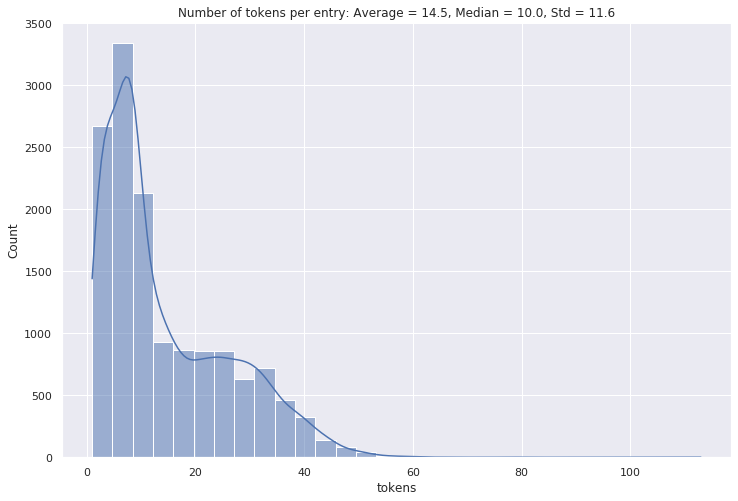

In [ ]:
# Histogram of token lengths
plt.figure(figsize=(12, 8))
sns.histplot(df['tokens'].apply(lambda x: len(x)), bins = 30, kde = True)
plt.title('Number of tokens per entry: Average = {}, Median = {}, Std = {}'.format(
    round(
      df['tokens'].apply(lambda x: len(x)).mean(), 2),
    round(
      df['tokens'].apply(lambda x: len(x)).median(), 2), 
    round(
      df['tokens'].apply(lambda x: len(x)).std(), 2),
    )
)
plt.show()

The graph above shows the distribution of the number of tokens and the number of occurence. The average number per token by entry (row in dataframe) is 14.5 with a median of 10.0 tokens and and standard-deviation of 11.6 tokens.  

#### IOB Schema
Let's also have a look at the ground-truth, prediction of `en_core_web_lg` and prediction of `en_core_web_trf`: 

Text(0.5, 1.0, 'NER tags considering IOB by tag and model')

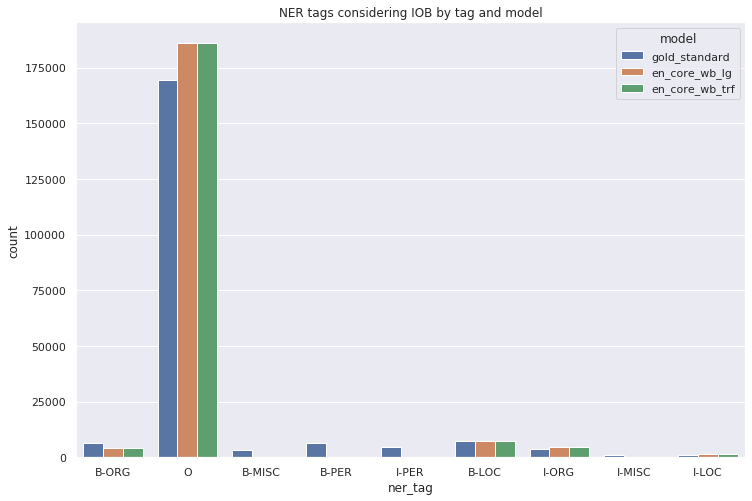

In [ ]:
gold_flat = list(itertools.chain(*df.gold_standard))
nlp_flat = list(itertools.chain(*df.nlp_pred))
trf_flat = list(itertools.chain(*df.nlp_pred))


def get_count(flat_version):
  """
  This function creates a dictionary with the count values per NER. 
  Parameters:
    flatten version of gold_standard or prediction
  Return:
    a dictionary with the total count of NER tags
  """
  token_count = {}
  n = 1
  for key in flat_version:
    if key in token_count:
      token_count[key] += 1
    else:
      token_count[key] = 1
  return {k:[v] for k,v in token_count.items()}

# Concatinate the results in a single dataframe for post-processing/analysis.
results = pd.concat([
                     pd.DataFrame(get_count(gold_flat)).T.reset_index().assign(model = 'gold_standard').rename(columns={'index':'ner_tag', 0:'count'}),
                     pd.DataFrame(get_count(nlp_flat)).T.reset_index().assign(model = 'en_core_wb_lg').rename(columns={'index':'ner_tag', 0:'count'}),
                     pd.DataFrame(get_count(trf_flat)).T.reset_index().assign(model = 'en_core_wb_trf').rename(columns={'index':'ner_tag', 0:'count'}),
                     ])

# Create a barplot with all prediciton sorted by model: gold_standard, lg predictions or transformers prediction
plt.figure(figsize=(12, 8))
sns.barplot(
    x = results['ner_tag'],
    y = results['count'],
    data = results,
    hue = 'model'
)
plt.title('NER tags considering IOB by tag and model')

The graph above shows the comparison between the number of occurence of each NER entity in IOB schema by ground-truth and both models. 
It is visible, that for some categories, the number predictions are higher as the ground-truth and the other way around. For some categories, both models are not performing and recognising the entities at all.  

Let's now repeat the same procedure one more time, neglecting the IOB schema. 

#### NER only
Let's now switch the focus away from IOB and check only the NER performance. 

Text(0.5, 1.0, 'NER tags not considering IOB by tag and model')

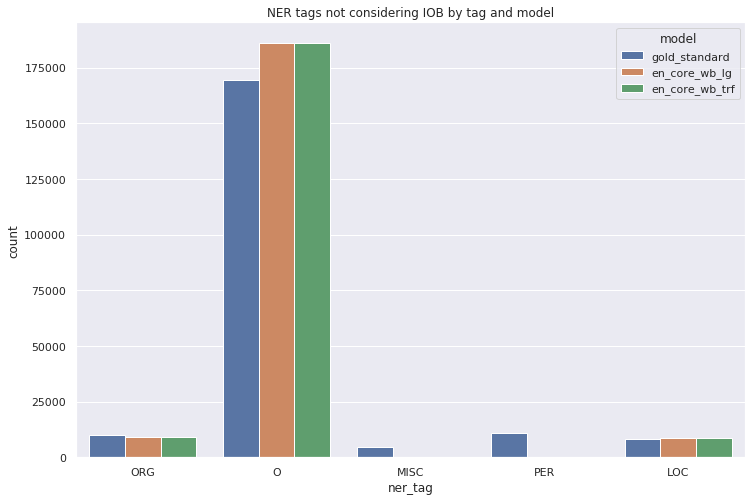

In [ ]:
# Let's now flatten everything again and remove the IOB - see element[2:] - prefix of each NER
gold_flat = [element[2:] if element != 'O' else element for element in list(itertools.chain(*df.gold_standard))]
nlp_flat = [element[2:] if element != 'O' else element for element in list(itertools.chain(*df.nlp_pred))]
trf_flat = [element[2:] if element != 'O' else element for element in list(itertools.chain(*df.nlp_pred))]

# Concatinate the results in a single dataframe for post-processing/analysis.
results = pd.concat([
                     pd.DataFrame(get_count(gold_flat)).T.reset_index().assign(model = 'gold_standard').rename(columns={'index':'ner_tag', 0:'count'}),
                     pd.DataFrame(get_count(nlp_flat)).T.reset_index().assign(model = 'en_core_wb_lg').rename(columns={'index':'ner_tag', 0:'count'}),
                     pd.DataFrame(get_count(trf_flat)).T.reset_index().assign(model = 'en_core_wb_trf').rename(columns={'index':'ner_tag', 0:'count'}),
                     ])

# Create a barplot with all prediciton sorted by model: gold_standard, lg predictions or transformers prediction
plt.figure(figsize=(12, 8))
sns.barplot(
    x = results['ner_tag'],
    y = results['count'],
    data = results,
    hue = 'model'
)
plt.title('NER tags not considering IOB by tag and model')

Neglecting the IOB schema one gets, nevertheless, a similar performance.  
It is already now clear, that the models would have to to learn PER NER and MISC (not PER, LOC, ORG). This could be done by transfer-learning techniques. 

### Evaluation by Metric

![](https://miro.medium.com/max/471/1*vWHXm3y9gLLVtNwya9HkdQ.png)

- **Precision**  
The ratio of correct positive predictions to the overall number of **positive predictions** in the dataset:  
$Precision = \frac{TP}{TP+FP}$  


- **Recall**  
The ratio of correct positive predictions to the overall number of **positive examples** in the dataset.  
$Recall = \frac{TP}{TP+FN}$  

- **f1-score**  
A weighted combination of both precision and recall.  
$F1 = 2 \cdot \frac{TP \cdot FN}{TP+FN}$  
The F1 score is a measure of a test’s accuracy — it is the harmonic mean of precision and recall. It can have a maximum score of 1 (perfect precision and recall) and a minimum of 0. Overall, it is a measure of the preciseness and robustness of your model.  

#### Performance per label type and token  
First of all, let's now proceed and check the results considering the NER and IOB schema. The focus will be set to the f1-score, which is the compromise between Precision and recall. 

In [ ]:
# First, flatten ground truth and predictions into two separate lists
truth_flat = list(itertools.chain(*df.gold_standard))
preds_flat_lg = list(itertools.chain(*df.nlp_pred))
preds_flat_trf = list(itertools.chain(*df.trf_pred))
target_names = list(ner_tags_map.keys())

# Get the performance metric for each model
nlp_metrics_full = metrics.classification_report(truth_flat, preds_flat_lg, labels = target_names, zero_division=1, output_dict = True)
trf_metrics_full = metrics.classification_report(truth_flat, preds_flat_trf, labels = target_names, zero_division=1, output_dict = True)

# For later postprocessing steps, let's gather the two performance metrics into df. 
df_nlp_metrics_full = (pd.DataFrame(data = nlp_metrics_full, columns = list(nlp_metrics_full.keys()))
    .T
    .reset_index()
    .assign(model = 'en_core_web_lg')
    .rename(columns = {'index':'categories','f1-score':'f1_score'})
    )

# For later postprocessing steps, let's gather the two performance metrics into df. 
df_trf_metrics_full = (pd.DataFrame(data = trf_metrics_full, columns = list(trf_metrics_full.keys()))
    .T
    .reset_index()
    .assign(model = 'en_core_web_trf')
    .rename(columns = {'index':'categories','f1-score':'f1_score'})
    )

# Let's also gather the results all in one for the following next plot
result = pd.concat([df_nlp_metrics_full, df_trf_metrics_full]).drop(columns=['support'])

# Define target space and print-out performance
target_names = list(ner_tags_map.keys())
print(':'*30,'Evaluation on token level',':'*30)
print('-'*80,'\n Ground Truth vs. Spacy Large English model')
print(metrics.classification_report(truth_flat, preds_flat_lg, labels = target_names, zero_division=1))
print('-'*80,'\n Ground Truth vs. Spacy Transformers')
print(metrics.classification_report(truth_flat, preds_flat_trf, labels = target_names, zero_division=1))
print('-'*80)

:::::::::::::::::::::::::::::: Evaluation on token level ::::::::::::::::::::::::::::::
-------------------------------------------------------------------------------- 
 Ground Truth vs. Spacy Large English model
              precision    recall  f1-score   support

           O       0.90      0.99      0.94    169578
       B-PER       1.00      0.00      0.00      6600
       I-PER       1.00      0.00      0.00      4528
       B-ORG       0.57      0.39      0.46      6321
       I-ORG       0.49      0.61      0.54      3704
       B-LOC       0.78      0.81      0.80      7140
       I-LOC       0.62      0.68      0.65      1157
      B-MISC       1.00      0.00      0.00      3438
      I-MISC       1.00      0.00      0.00      1155

    accuracy                           0.88    203621
   macro avg       0.82      0.39      0.38    203621
weighted avg       0.88      0.88      0.84    203621

-------------------------------------------------------------------------------- 

What one can definitely say, ist the some categories are perform quite well with the basis model, while others seems to have a Precision and Recall problem and last and least, for some categories the performance is very bad.
Namely speaking, let's now summarize the performance from good to bad:

- 1) O
- 2) B-LOC            
- 3) I-LOC
- 4) I-ORG
- 5) B-ORG
- 6) B-PER & I-PER 

What can be definively said, is that PER NER is insufficient trained, as the score seems to be zero. 

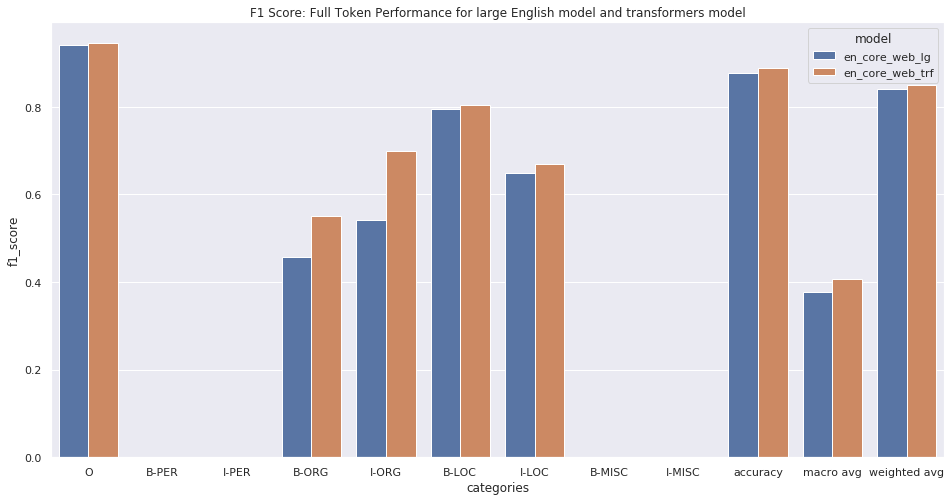

In [ ]:
# Barplot of f1 score
plt.figure(figsize=(16, 8))
sns.barplot(
    x = result.categories,
    y = result.f1_score,
    data = result,
    hue="model"
    )
plt.title('F1 Score: Full Token Performance for large English model and transformers model')
plt.show()

#### Performance over full named-entity
Again, not considering the IOB schema one gets the following performance values:

In [ ]:
# Generating the metrics report for both models
nlp_metrics_entity_only = classification_report(df.gold_standard, df.nlp_pred, scheme=IOB2, zero_division=1, output_dict = True)
trf_metrics_ = classification_report(df.gold_standard, df.trf_pred, scheme=IOB2, zero_division=1, output_dict = True)

# For later postprocessing steps, let's gather the two performance metrics into df. 
df_nlp_metrics_entity_only = (pd.DataFrame(data = nlp_metrics_entity_only, columns = list(nlp_metrics_entity_only.keys()))
    .T
    .reset_index()
    .assign(model = 'en_core_web_lg')
    .rename(columns = {'index':'categories','f1-score':'f1_score'})
    )

# For later postprocessing steps, let's gather the two performance metrics into df. 
df_trf_metrics_entity_only = (pd.DataFrame(data = trf_metrics_, columns = list(trf_metrics_.keys()))
    .T
    .reset_index()
    .assign(model = 'en_core_web_trf')
    .rename(columns = {'index':'categories','f1-score':'f1_score'})
    )

# Let's also gather the results all in one for the following next plot
results = pd.concat([df_nlp_metrics_entity_only,df_trf_metrics_entity_only])

# Define target space and print-out performance
print(':'*30,'Evaluation merging B and I flags',':'*30)
print('-'*80,'\n Ground Truth vs. Spacy Large English model')
print(classification_report(df.gold_standard, df.nlp_pred, scheme=IOB2, zero_division=1))
print('-'*80,'\n Ground Truth vs. Spacy Transformers')
print(classification_report(df.gold_standard, df.trf_pred, scheme=IOB2, zero_division=1))
print('-'*80)

:::::::::::::::::::::::::::::: Evaluation merging B and I flags ::::::::::::::::::::::::::::::
-------------------------------------------------------------------------------- 
 Ground Truth vs. Spacy Large English model
              precision    recall  f1-score   support

         LOC       0.78      0.80      0.79      7140
        MISC       1.00      0.00      0.00      3438
         ORG       0.49      0.33      0.39      6321
         PER       1.00      0.00      0.00      6600

   micro avg       0.67      0.33      0.44     23499
   macro avg       0.82      0.28      0.30     23499
weighted avg       0.79      0.33      0.35     23499

-------------------------------------------------------------------------------- 
 Ground Truth vs. Spacy Transformers
              precision    recall  f1-score   support

         LOC       0.76      0.84      0.80      7140
        MISC       1.00      0.00      0.00      3438
         ORG       0.72      0.42      0.53      6321
        

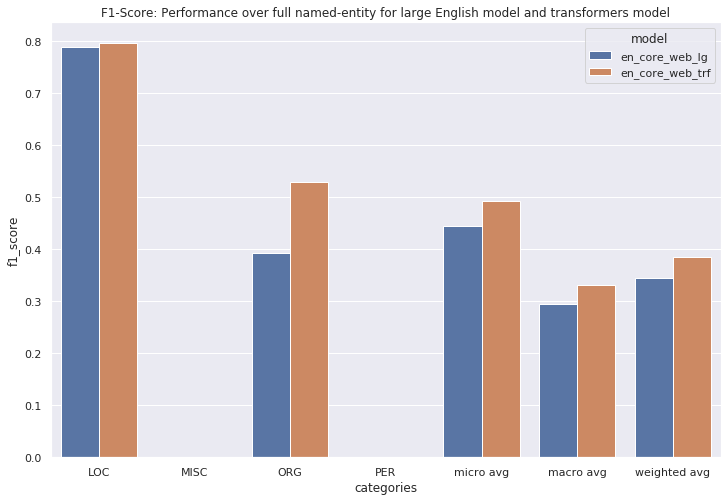

In [ ]:
# Barplot of f1 score
plt.figure(figsize=(12, 8))
sns.barplot(
    x = results.categories,
    y = results.f1_score,
    data = results,
    hue="model"
    )
plt.title('F1-Score: Performance over full named-entity for large English model and transformers model')
plt.show()

Again, the LOC performance is slightly better than before considering the IOB schema. ORG performance is approximately the same here as well. 

#### Precision & Recall

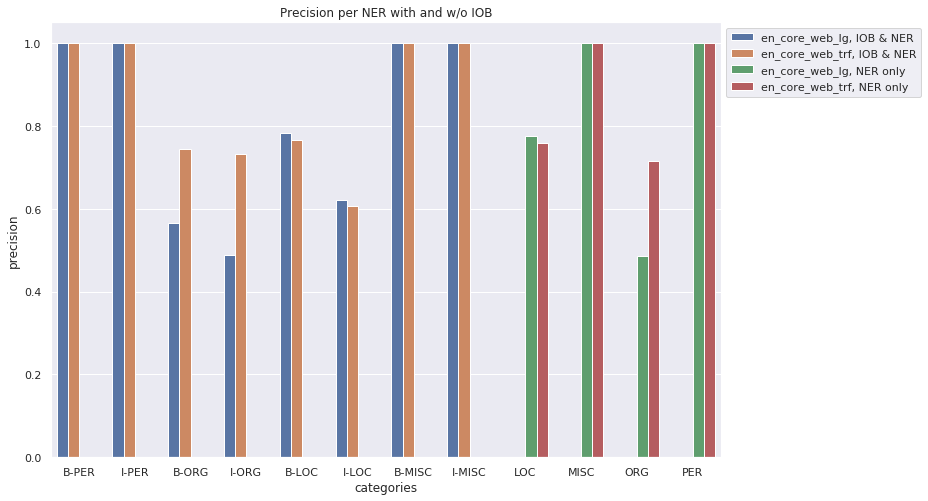

In [ ]:
# Combine all metrics into a metrics full df
metrics_full = (pd.concat(
    [
        (df_nlp_metrics_full
          .assign(model_type = lambda x: x.model.astype(str) + ', IOB & NER')
          .drop(columns=['support','model'])
          ),
        (df_trf_metrics_full
          .assign(model_type = lambda x: x.model.astype(str) + ', IOB & NER')
          .drop(columns=['support','model'])
          ),
        (df_nlp_metrics_entity_only
          .assign(model_type = lambda x: x.model.astype(str) + ', NER only')
          .drop(columns=['support','model'])
          ),
        (df_trf_metrics_entity_only
          .assign(model_type = lambda x: x.model.astype(str) + ', NER only')
          .drop(columns=['support','model'])
          ),
      ]
    )
)

# Filter out values such as accuracy, macro avg, weighted avg and O tags, in order to compare the performance
metrics_full = (
    metrics_full[
                 (metrics_full.categories != 'accuracy') & 
                 (metrics_full.categories != 'macro avg') & 
                 (metrics_full.categories != 'weighted avg') & 
                 (metrics_full.categories != 'micro avg') & 
                 (metrics_full.categories != 'O')
                 ]
                )#.replace(to_replace = r'[A-Za-z]-',value = '',regex=True)

# Create a Precision plot
plt.figure(figsize=(12, 8))
sns.barplot(
    x = metrics_full.categories,
    y = metrics_full.precision,
    data = metrics_full,
    hue="model_type",
    )
plt.title('Precision per NER with and w/o IOB')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

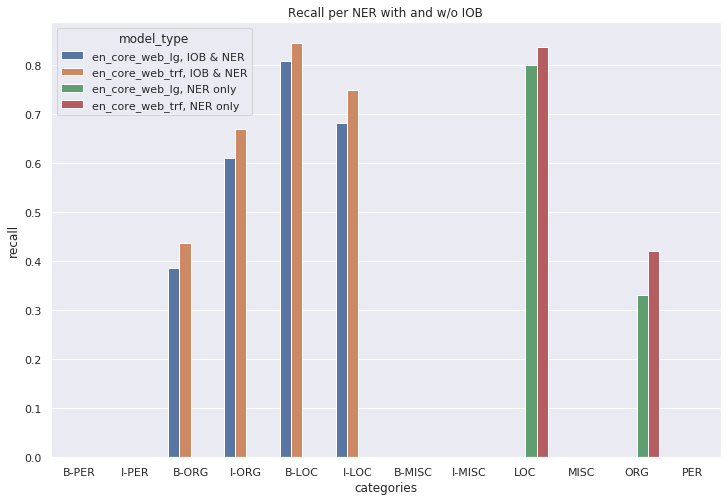

In [ ]:
# Create a Recall plot
plt.figure(figsize=(12, 8))
sns.barplot(
    x = metrics_full.categories,
    y = metrics_full.recall,
    data = metrics_full,
    hue="model_type",
    )
plt.title('Recall per NER with and w/o IOB')
plt.show()

## Final Words  
In this exercise I have tried to compare the performance of the Spacy's large English model `en_core_web_lg` and `en_core_web_trf` on the same corpus.  

The corpus provided by Huggingface `conllpp` contains three different subsets: 

- Train with a shape of: (14041, 5)
- Test with a shape of: (3453, 5)
- Validation with a shape of: (3250, 5)

The comparison was done with the largest dataset, train, in order to have the largest amount of NER identification. This report provides evidence, which named entities have to be added via e.g. Transferlearning in order to increase the performance of the NER framework.  
The transformers based model needed approximatly 15x longer than the large english model on the same df and method applied. Summarzing, that the performance of the transformers model was better almost for every NER and IOB and worst on computation time. A separate analysis of the model running on a GPU based environment would have to be investigated. 

The evaluation of the metric was difficult for me, as a complete analysis would alone provide a complete new report checking the possible metrics and error modes ([source: David S Batista](https://www.davidsbatista.net/blog/2018/05/09/Named_Entity_Evaluation/)). The suggested best-practice approach would have been to check as well the following modes:  

- Strict: exact boundary surface string match and entity type;
- Exact: exact boundary match over the surface string, regardless of the type;
- Partial: partial boundary match over the surface string, regardless of the type;
- Type: some overlap between the system tagged entity and the gold annotation is required;

